# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

In [2]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [3]:
import re
from random import shuffle
from glob import glob

In [4]:
!pwd

/kaggle/working


In [5]:
train_files = glob('../input/train/*.jpg')
test_files = glob('../input/test/*.jpg')

In [6]:
# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    #добавим аугментацию
    datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
    
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            
            # compute quantities required for featurewise normalization
            datagen.fit(x)
            
            yield next(datagen.flow(x, y, batch_size=batch_size))

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

In [44]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

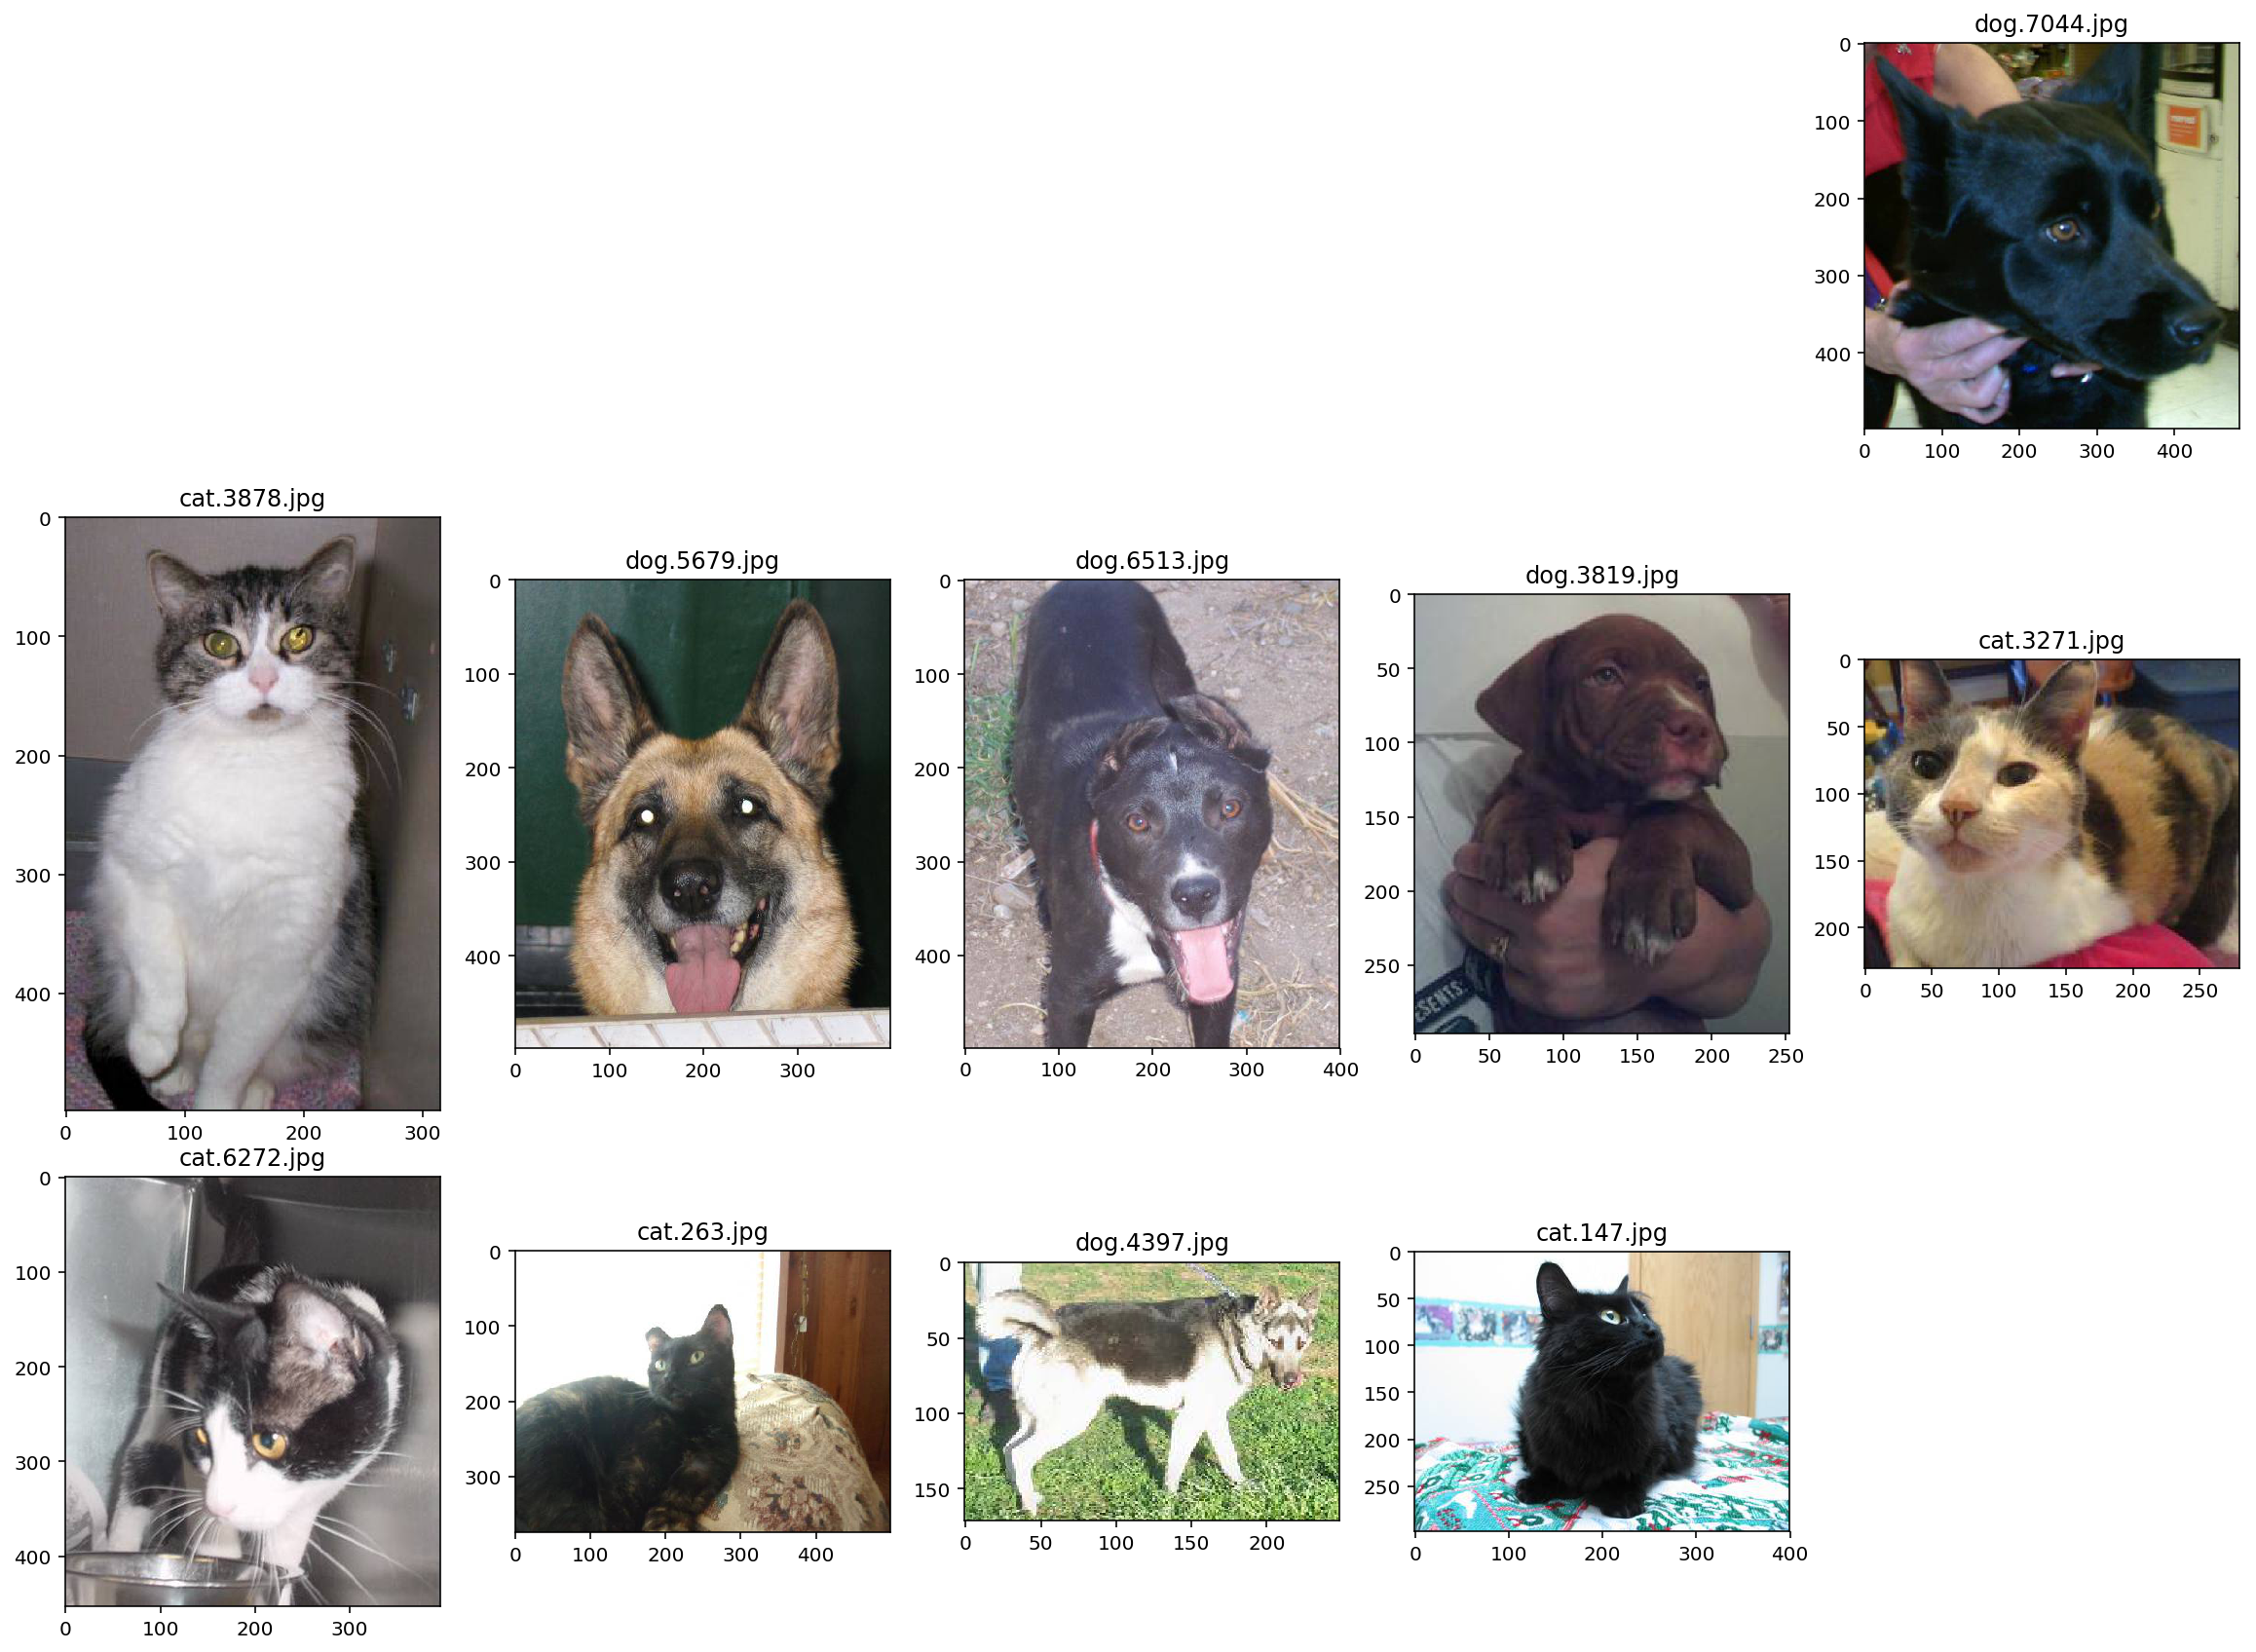

In [50]:
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [9]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

58892288/58889256 [==============================] - 1s 0us/step


In [10]:
base_model.layers

In [11]:
# фиксируем веса предобученной сети
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [ ]:
# попробуем обучить модель с добавлением одного слоя, посмотрим на результат
# результат был 1.84185 (logloss),  что не удовлятворяет требованию дз
# результат был 1.57971 (logloss),  что не удовлятворяет требованию дз
# результат 0.28766 (logloss),  что удовлятворяет требованию дз
# внесем изменнеия в модель

In [21]:
x = base_model.layers[-1].output
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(
    kernel_size = (3,3), filters = 512, activation='sigmoid', kernel_regularizer=keras.regularizers.l1(1e-4)
                )(x)

x = keras.layers.Conv2D(
    kernel_size = (5,5), filters = 256, activation='sigmoid', kernel_regularizer=keras.regularizers.l1(1e-4)
                )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(3e-4))(x)


model = Model(inputs=base_model.input, outputs=x)


## Выводим архитектуру модели

In [22]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Компилируем модель и запускаем обучение

In [23]:
model.compile(optimizer=keras.optimizers.Adam(lr=3e-4),
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [24]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=200,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/200
10/10 [==============================] - 7s 673ms/step - loss: 6.2765 - acc: 0.8656 - val_loss: 5.9936 - val_acc: 0.8400
Epoch 2/200
10/10 [==============================] - 5s 536ms/step - loss: 5.5899 - acc: 0.9656 - val_loss: 5.8064 - val_acc: 0.9400
Epoch 3/200
10/10 [==============================] - 5s 543ms/step - loss: 5.2850 - acc: 0.9781 - val_loss: 5.3019 - val_acc: 0.9300
Epoch 4/200
10/10 [==============================] - 6s 554ms/step - loss: 5.1752 - acc: 0.9594 - val_loss: 5.2666 - val_acc: 0.7800
Epoch 5/200
10/10 [==============================] - 6s 554ms/step - loss: 4.8343 - acc: 0.9375 - val_loss: 5.0126 - val_acc: 0.5700
Epoch 6/200
10/10 [==============================] - 5s 541ms/step - loss: 4.4655 - acc: 0.9656 - val_loss: 4.7520 - val_acc: 0.6100
Epoch 7/200
10/10 [==============================] - 5s 546ms/step - loss: 4.2212 - acc: 0.9656 - val_loss: 4.4575 - val_acc: 0.6400
Epoch 8/200
10/10 [==============================] - 6s 556ms/step - 

10/10 [==============================] - 5s 545ms/step - loss: 0.0845 - acc: 0.9844 - val_loss: 0.1525 - val_acc: 0.9700
Epoch 124/200
10/10 [==============================] - 6s 569ms/step - loss: 0.1243 - acc: 0.9656 - val_loss: 0.2534 - val_acc: 0.9200
Epoch 125/200
10/10 [==============================] - 5s 546ms/step - loss: 0.1055 - acc: 0.9750 - val_loss: 1.0271 - val_acc: 0.7600
Epoch 126/200
10/10 [==============================] - 5s 547ms/step - loss: 0.1368 - acc: 0.9594 - val_loss: 1.7991 - val_acc: 0.5400
Epoch 127/200
10/10 [==============================] - 6s 553ms/step - loss: 0.1205 - acc: 0.9719 - val_loss: 0.6999 - val_acc: 0.6700
Epoch 128/200
10/10 [==============================] - 5s 543ms/step - loss: 0.0882 - acc: 0.9812 - val_loss: 0.1139 - val_acc: 1.0000
Epoch 129/200
10/10 [==============================] - 6s 555ms/step - loss: 0.1252 - acc: 0.9750 - val_loss: 1.1500 - val_acc: 0.8200
Epoch 130/200
10/10 [==============================] - 6s 562ms/step 

Epoch 184/200
10/10 [==============================] - 6s 564ms/step - loss: 0.0821 - acc: 0.9906 - val_loss: 0.2651 - val_acc: 0.9600
Epoch 185/200
10/10 [==============================] - 6s 555ms/step - loss: 0.0875 - acc: 0.9844 - val_loss: 0.1742 - val_acc: 0.9700
Epoch 186/200
10/10 [==============================] - 6s 561ms/step - loss: 0.0805 - acc: 0.9812 - val_loss: 0.1258 - val_acc: 0.9700
Epoch 187/200
10/10 [==============================] - 6s 552ms/step - loss: 0.0929 - acc: 0.9781 - val_loss: 0.3000 - val_acc: 0.9700
Epoch 188/200
10/10 [==============================] - 5s 546ms/step - loss: 0.0971 - acc: 0.9625 - val_loss: 0.3153 - val_acc: 0.9700
Epoch 189/200
10/10 [==============================] - 6s 553ms/step - loss: 0.0982 - acc: 0.9781 - val_loss: 0.1283 - val_acc: 0.9800
Epoch 190/200
10/10 [==============================] - 6s 555ms/step - loss: 0.1172 - acc: 0.9688 - val_loss: 0.3265 - val_acc: 0.9500
Epoch 191/200
10/10 [==============================] - 

In [ ]:
#model.save('cats-dogs-vgg16.hdf5')

## Предсказания на проверочной выборке

In [25]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

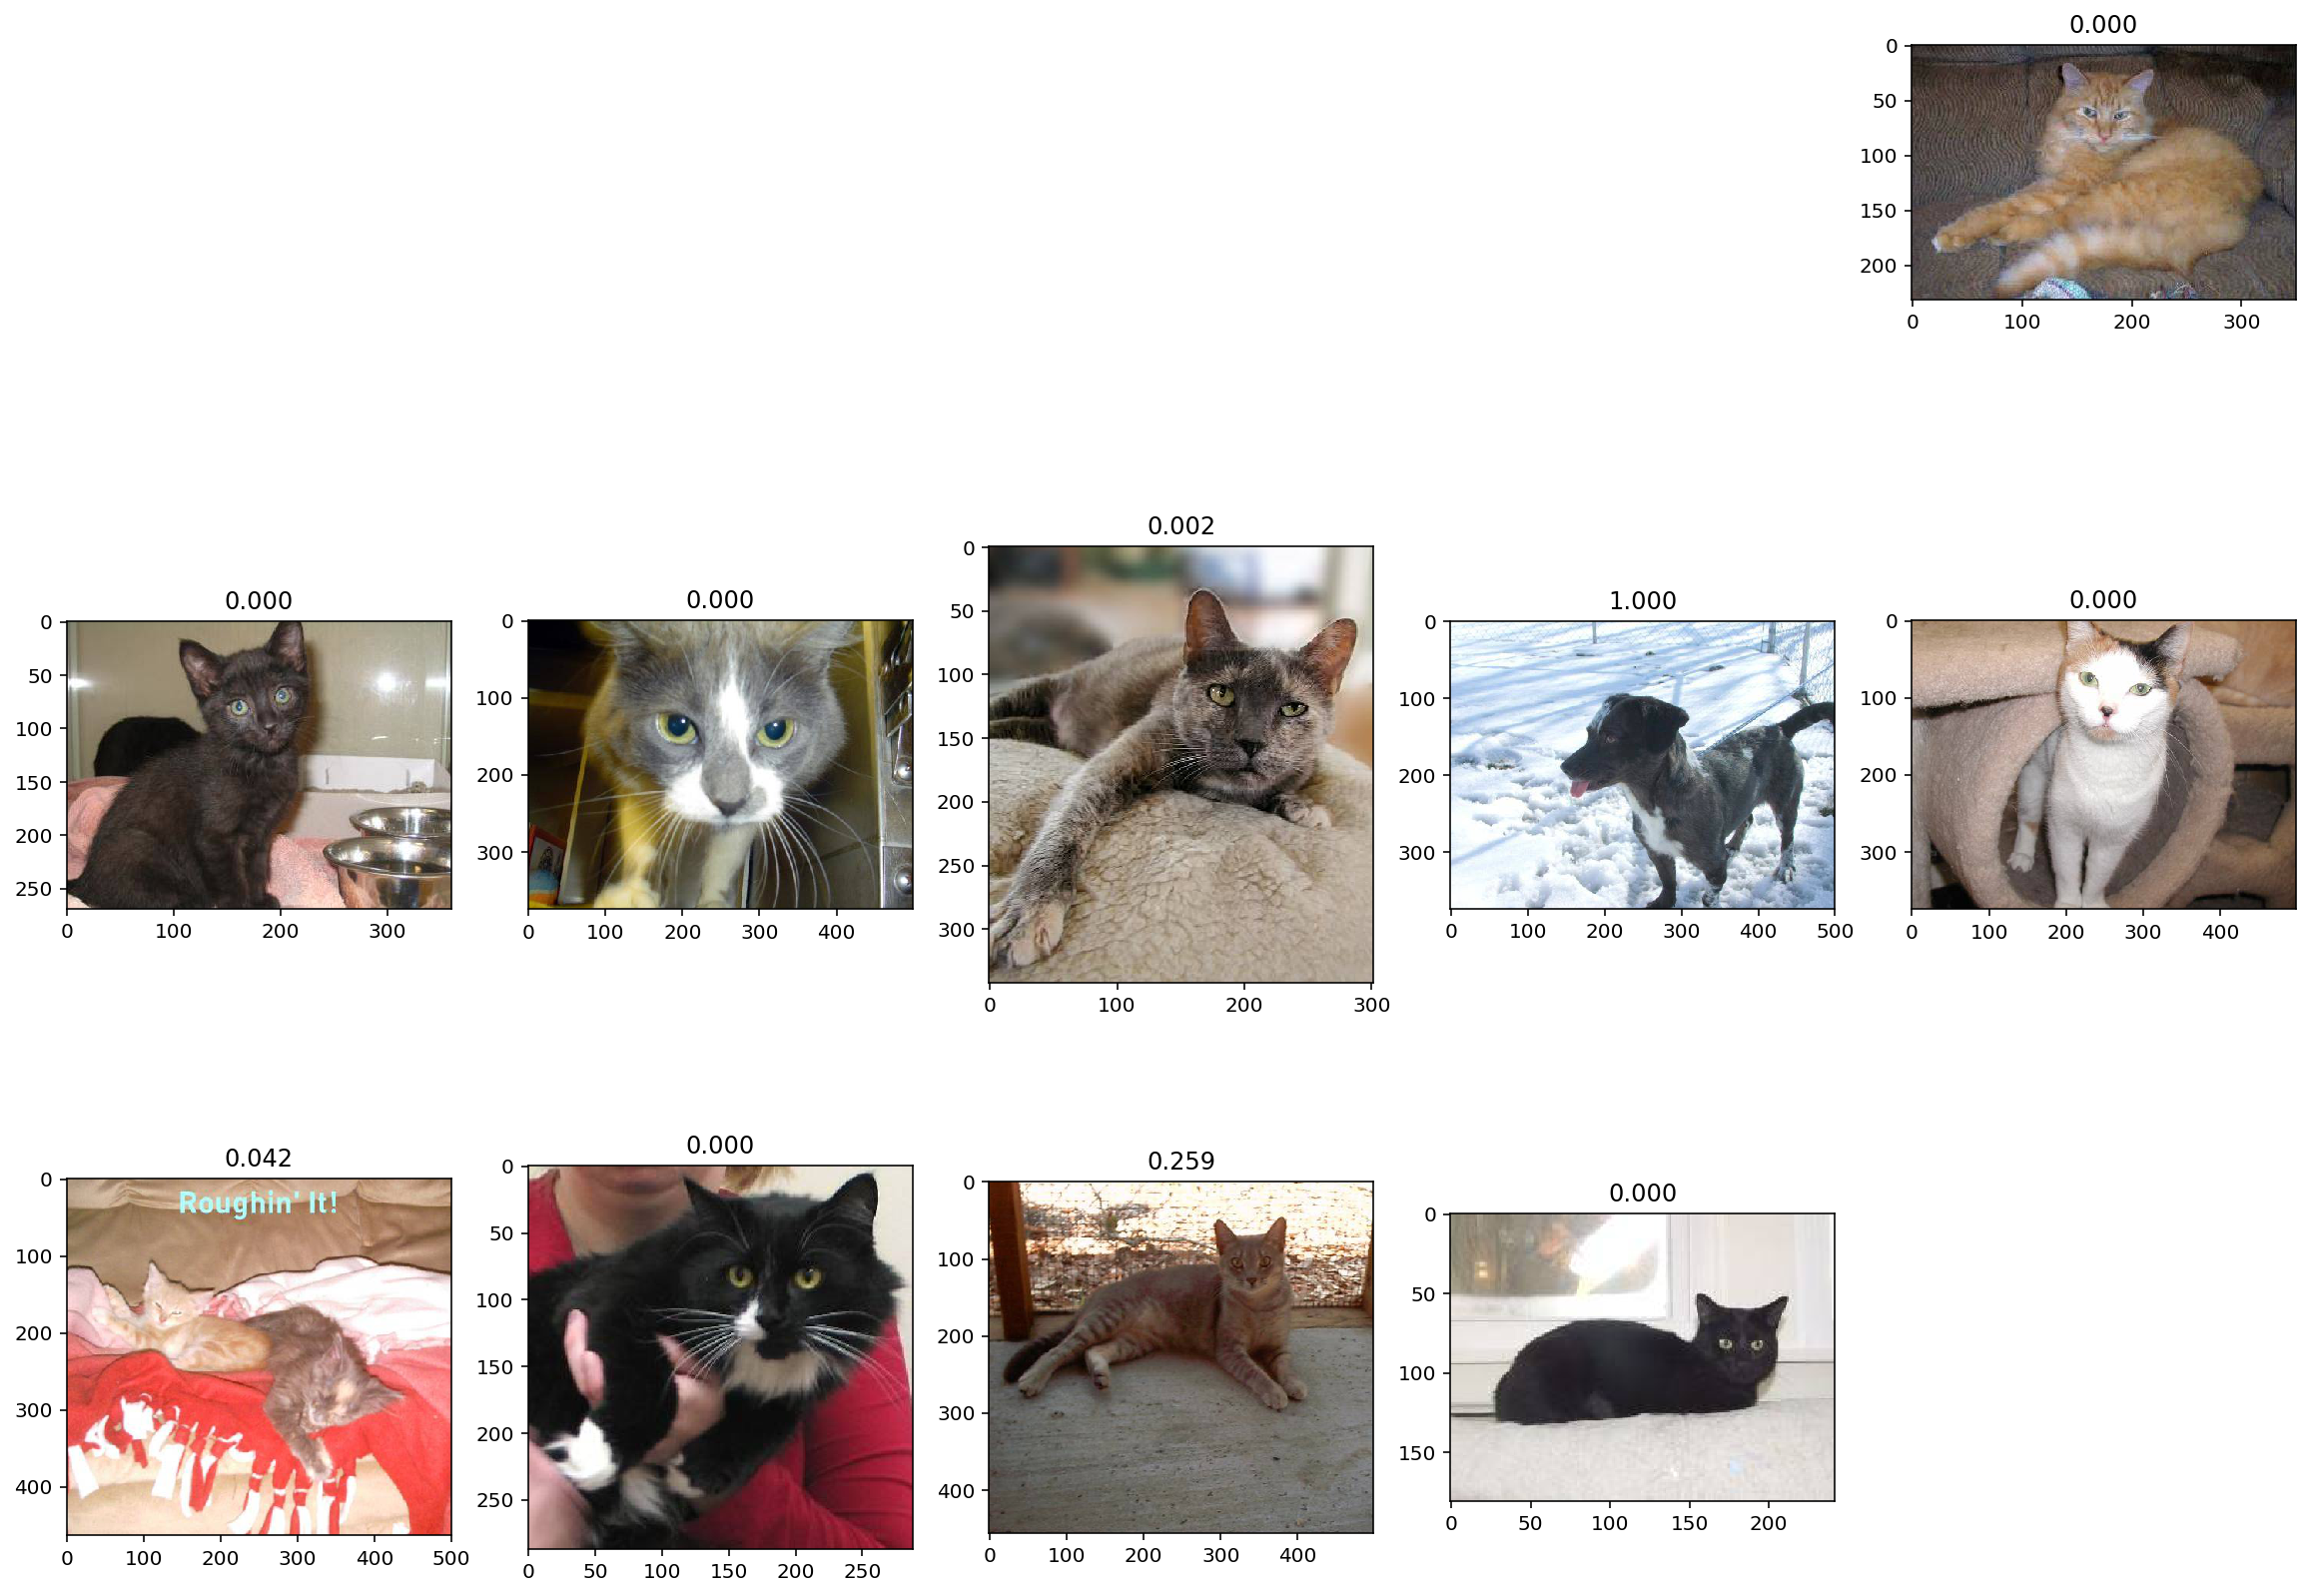

In [26]:
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [27]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [2]:
from IPython.display import Image

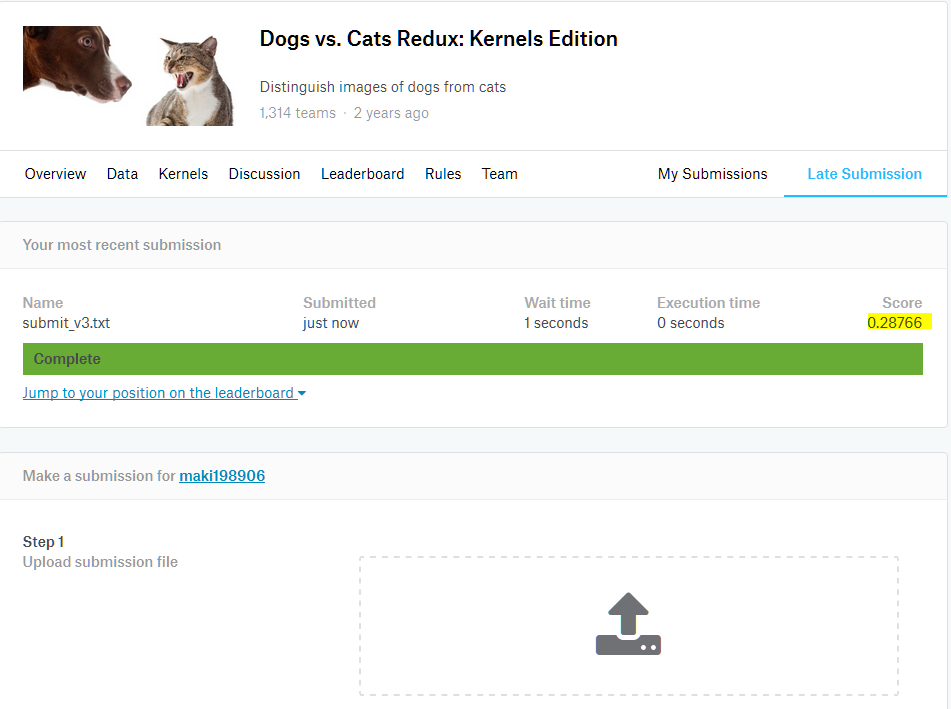

In [3]:
Image('To_submit_v3.png')